In [1]:
data_directory ="IV_meas/Harald "

"""Key to sample labelling and data:
Box B = the samples defined with shadowmask sputtering; rows = 8, 12, 16 % lanthanum, columns = 500, 600 C anneal
Box C = 6, 12 % samples 175 C recipe - second run with shadowmask sputtering.
Box D = 8 % samples 175 C recipe - not processed further.
Box E = 8 % samples 190 C recipe - proper litho techniques
Box F = 8 % samples 190 C recipe, intended for the FLA - not processed further.
Box G = 4 % samples 190 C recipe - proper litho techniques
Box H = 6 % samples 190 C recipe - proper litho techniques
Box I = 10 % samples 190 C recipe - proper litho techniques
Box J = 12 % samples 190 C recipe - proper litho techniques

E, G, H, I, J: samples 1, 2, 3 = 500, 600, 700 C anneal. Samples 4 = 800 C - could not be etched -> not included.
Samples 5-9 were not processed, except for G where 7, 8, 9 were put in the FLA with preheat temp of 350, 300, 250 respectively. 
G6 was lost during processing as it was dropped into a wet bench. For each box (E-J): 
samples 1-5 were processed in the ALD together, as were 6-9.
"""

'Key to sample labelling and data:\nBox B = the samples defined with shadowmask sputtering; rows = 8, 12, 16 % lanthanum, columns = 500, 600 C anneal\nBox C = 6, 12 % samples 175 C recipe - second run with shadowmask sputtering.\nBox D = 8 % samples 175 C recipe - not processed further.\nBox E = 8 % samples 190 C recipe - proper litho techniques\nBox F = 8 % samples 190 C recipe, intended for the FLA - not processed further.\nBox G = 4 % samples 190 C recipe - proper litho techniques\nBox H = 6 % samples 190 C recipe - proper litho techniques\nBox I = 10 % samples 190 C recipe - proper litho techniques\nBox J = 12 % samples 190 C recipe - proper litho techniques\n\nE, G, H, I, J: samples 1, 2, 3 = 500, 600, 700 C anneal. Samples 4 = 800 C - could not be etched -> not included.\nSamples 5-9 were not processed, except for G where 7, 8, 9 were put in the FLA with preheat temp of 350, 300, 250 respectively. \nG6 was lost during processing as it was dropped into a wet bench. For each box (E

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re #allows string splitting and searching, used to find the voltage for labelling graphs
import matplotlib
from matplotlib.pyplot import figure

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
"""Takes a data_directory and returns the time, current, bias"""
def dataCollection(file):
    indexnames = pd.read_csv(file, header = None, usecols = [0])
    skiplist = []

    for c, item in enumerate(indexnames.values[:]):
        if item != "DataValue":
            skiplist.append(c)
    treated_data = pd.read_csv(file, header = [0, 4999], skiprows = skiplist, index_col = 0)
    time = treated_data.values[1:,0].astype(float)
    curr = treated_data.values[1:,1].astype(float)
    pot = treated_data.values[1:,2].astype(float)
    return(time, -curr, pot)

In [5]:
"""Remanent polarization and Polarization list"""
def PVChar(time, curr, pot, MaxV):
    Q = []; q = 0
    for j in range(len(time)): #"integarting" the current.
        q += curr[j]-curr[0]
        Q.append(q)
    Q = np.array(Q)*1e6*(time[1]-time[0]) #converst the list of charge vs time into an array with the unit uC instead.
    r = 25e-04 #cm
    A = np.pi*r**2 #cm2
    Pol = np.array(Q).astype(float)/A #normalizes by the area of the devices, unit is uC/cm2.

    """The following is needed to calculate the remanent polarization"""
    pulse_length = 800 #number of data points in the triangle wave
    P0 = 1100; U0 = 2100; N0 = 3100; D0 = 4100 #points where the 4 triangle waves start
    Pol1 = Pol[P0:P0+pulse_length]-Pol[U0:U0+pulse_length] #takes the difference between P and U
    Pol2 = Pol[N0:N0+pulse_length]-Pol[D0:D0+pulse_length] #difference between N and D
    Pol2 = Pol2 - (Pol2[0] - Pol1[-1]) #aligns the two with each other - Pol2 is set to start where Pol1 ends.
    pr = (Pol1[-1]-Pol2[-1])/2 #takes the difference between the two points where U = 0 and divides this by 2.
    return(Pol,pr)

In [6]:
def Capacitance(time, curr, pot):
    dv = pot[1]-pot[0]
    dt = time[1]-time[0]
    C = curr/(dv/dt)
    return(np.median(C))

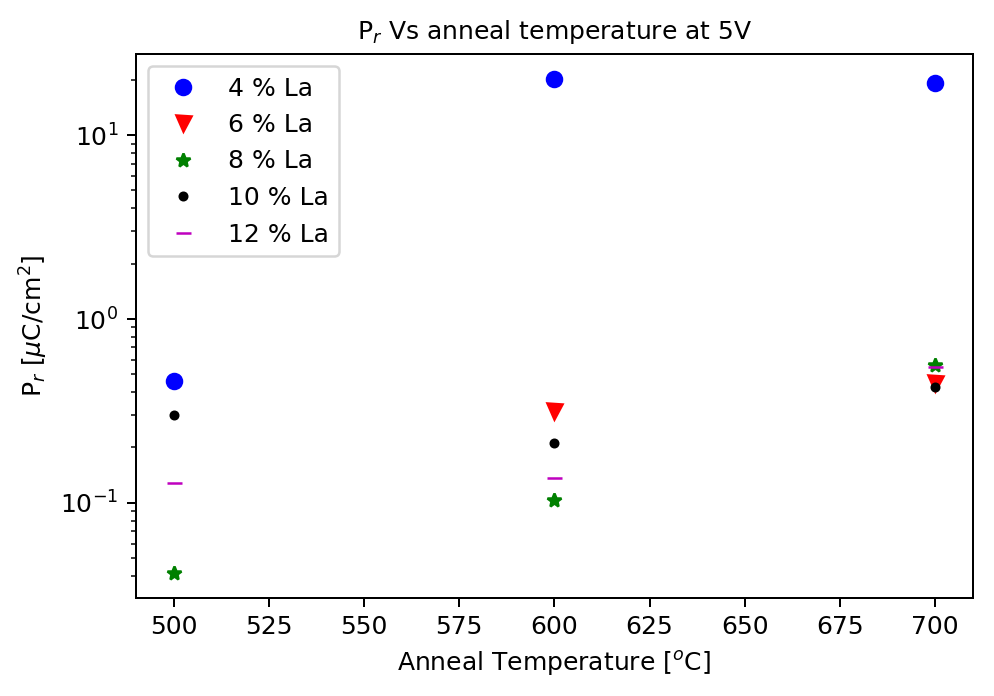

In [7]:
"""Plotting remanent polarization as a function of the anneal temperature, with the various concentrations as the labels."""
sampleboxes = ['G','H','E','I','J']; concs = [4,6,8,10,12]; samples = ['1','2','3']; temps = [500,600,700]

bias = 5 # peak bias in Volts, valid values are 3, 4, and 5
markers = ['bo', 'rv', 'g*', 'k.', 'm_']
figure(num=None, dpi=180, facecolor='w', edgecolor='k')

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

for i in range(len(sampleboxes)): #This loop cycles through the concentrations - will end up as the legend
    box = sampleboxes[i];    PRs = [];    conc = concs[i] 
    #Defines which box for reading datafiles and which concentration this corresponds to.
    
    for j in range(len(samples)): #This loop cycles through the anneal temperatures - will end up as the x-axis.
        sample = samples[j]
        file = [f for f in glob.glob(data_directory + box + "/FE PUND "+str(bias)+"V**[Harald"+box+"_"+sample+"_dev2*.csv")][0]
        time, curr, pot = dataCollection(file)
        P, pr = PVChar(time, curr, pot, bias)
        PRs.append(pr)
    plt.plot(temps, PRs, markers[i] , label = str(conc) + ' % La')
plt.legend(loc = 2)
plt.ylabel('P$_r$ [$\mu$C/cm$^2$]')
plt.xlabel('Anneal Temperature [$^o$C]')
plt.yscale('log')
plt.title("P$_r$ Vs anneal temperature at "+str(bias)+"V")
figname = "EG-J1-3PrVsTemp"+str(bias)+"V_log"
# plt.savefig(IV_meas/PrResults/"+figname+'.png')
plt.show()

[1.2592212359110515, 1.7106974919637048, 2.0543766021728516]
[1.1937448978424074, 1.2441616853078208, 1.704549789428711]
[1.1987765630086267, 1.3305568695068362, 1.4630335172017415]


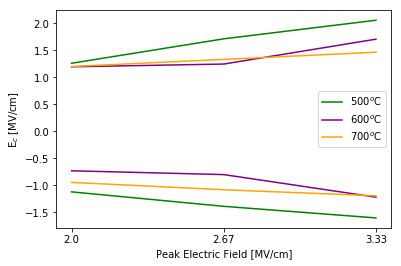

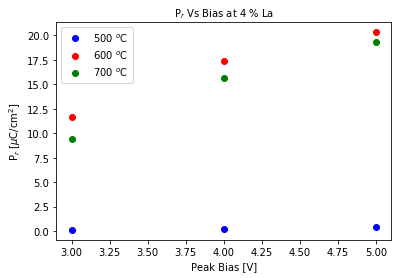

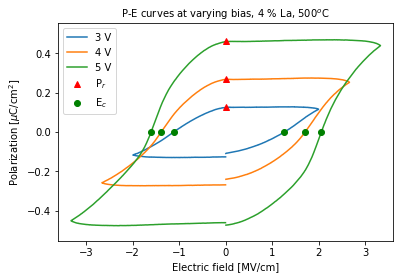

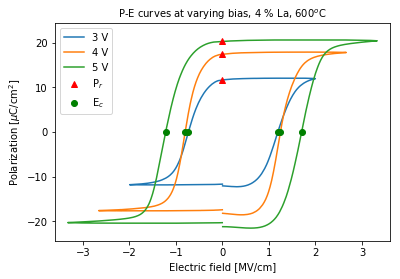

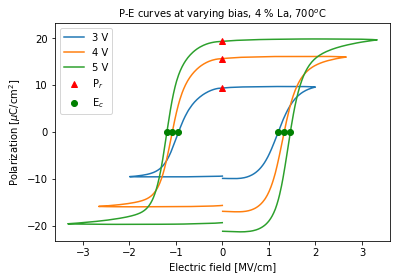

In [8]:
"""Plots the PE curves, coercive field vs peak bias, and remanent polarization vs peak bias."""
box = 'G' #Change box and conc to the relevant values. 'G' and 4 are "default" values.
conc = 4
samples = ['1','2','3']
temps = [500,600,700]
biases = [3,4,5]
dpi = 72 #resolution of the images. dpi = 72 is the default value, dpi = 180 was used for the images in the thesis.
markers = ['bo', 'ro', 'go']
fig3, ax3 = plt.subplots(dpi = dpi) #Ec vs peak bias
Ec_colors = ["green", "purple", 'orange']
fig2, ax2 = plt.subplots(dpi = dpi) #Pr vs peak bias
for i in range(len(temps)): #loop in temperature
    fig1, ax1 = plt.subplots(dpi = dpi) #PE curves
    pList = []
    PRs = []
    temp = temps[i]
    sample = samples[i]
    Ec1_list = []; Ec2_list = []
    for j in range(len(biases)): #loop in peak bias
        bias = biases[j]
        file = [f for f in glob.glob(data_directory + box + "/FE PUND "+str(bias)+"V**[Harald"+box+"_"+sample+"_dev2*.csv")][0]
        time, curr, pot = dataCollection(file)
        P, pr = PVChar(time, curr, pot, bias)
        pList.append(P)
        PRs.append(pr)
        P1 = P[1100:1900]-P[2100:2900]; P2 = P[3100:3900]-P[4100:4900]
        P1 = P1-(P1[-1]-pr); P2 = P2 - (P2[0] - P1[-1]) #defines the two halves of the polarization data
        pot = np.concatenate((pot[1100:1900], pot[3100:3900]))/(1e6*(15e-7))
        P = np.concatenate((P1,P2)) #concatenates the potential and polarization data to form single arrays
        legend_string = str(biases[j]) + " V"
        ax1.plot(pot, P, label = legend_string)
        ax1.plot(0, pr,'r^')
        Ec1 = pot[np.where(abs(P) == min(abs(P[0:800])))][0] 
        Ec2 = pot[np.where(abs(P) == min(abs(P[801:1600])))][0] #finds the bias at which the polarization is the smallest (Ec)
        Ec1_list.append(Ec1); Ec2_list.append(Ec2)
        ax1.plot(Ec1, 0, 'go')
        ax1.plot(Ec2, 0, 'go')
    ax1.plot(10,0,'r^', label = "P$_r$")
    ax1.plot(10,0,'go', label = "E$_c$")
    ax1.set_xlim(-3.6,3.6)
    ax1.set_ylim(-(pr*1.2), pr*1.2)
    ax1.set_xlabel('Electric field [MV/cm]')
    ax1.set_ylabel('Polarization [$\mu$C/cm$^2$]')
    title_string = "P-E curves at varying bias, " + str(conc) + " % La, " + str(temp) + "$^o$C"
    ax1.set_title(title_string)
    ax1.legend()
    color = Ec_colors[i]
    print(Ec1_list)
    ax3.plot(np.array(biases)/(1e6*(15e-7)), Ec1_list, label = str(temp) + "$^o$C", color = color)
    ax3.plot(np.array(biases)/(1e6*(15e-7)), Ec2_list, color = color)
    ax2.plot(biases, PRs, markers[i] , label = str(temp) + ' $^o$C')
ax3.set_ylabel("E$_c$ [MV/cm]")
ax3.set_xlabel("Peak Electric Field [MV/cm]")
ax3.set_xticks(np.array(biases)/(1e6*(15e-7)))
ax3.set_xticklabels(np.around(np.array(biases)/(1e6*(15e-7)),2))
ax3.legend()
ax2.legend(loc = 2)
ax2.set_ylabel('P$_r$ [$\mu$C/cm$^2$]')
ax2.set_xlabel('Peak Bias [V]')
ax2.set_title("P$_r$ Vs Bias at "+str(conc)+" % La")
figname = box+"1-3PrVsBias"+str(conc)+"pcLa"

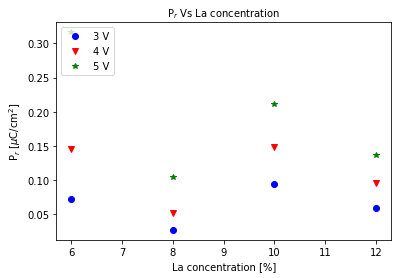

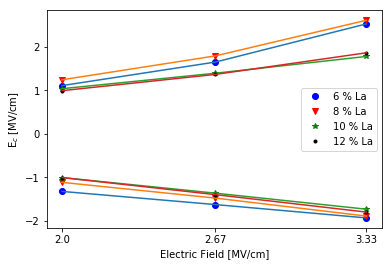

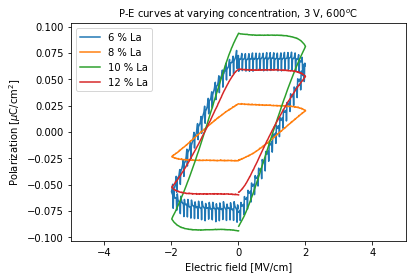

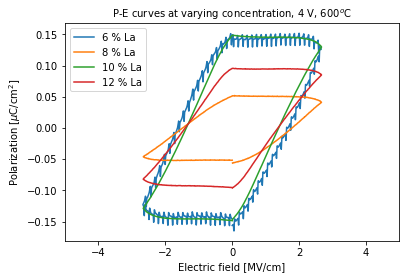

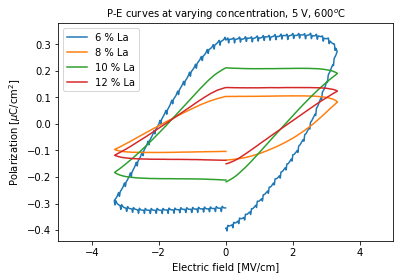

In [9]:
"""Plotting the data for the remaining concentrations as well."""
boxes = ['H','E','I','J']
concs = [6,8,10,12]
sample = "2"
temp = 600
biases = [3,4,5]
markers = markers = ['bo', 'rv', 'g*', 'k.', 'm_']
dpi = 72

fig2, ax2 = plt.subplots(dpi = dpi) #Pr vs Concentration
fig3, ax3 = plt.subplots(dpi = dpi) #Ec vs peak E-field

Ec1_list = np.empty((3,5)); Ec2_list = np.empty((3,5))
for i in range(len(biases)):
    pList = []
    PRs = []
    bias = biases[i]
    fig1, ax1 = plt.subplots(dpi = dpi) #PE curves
    for j in range(len(boxes)): #X-axis
        box = boxes[j];   conc = concs[j]
        file = [f for f in glob.glob(data_directory + box + "/FE PUND "+str(bias)+"V**[Harald"+box+"_"+sample+"_dev2*.csv")][0]
        time, curr, pot = dataCollection(file)
        P, pr = PVChar(time, curr, pot, bias)
        PRs.append(pr)
        P1 = P[1100:1900]-P[2100:2900]; P2 = P[3100:3900]-P[4100:4900]
        P1 = P1-(P1[-1]-pr); P2 = P2 - (P2[0] - P1[-1])
        pot = np.concatenate((pot[1100:1900], pot[3100:3900]))/(1e6*(15e-7))
        P = np.concatenate((P1,P2))
        legend_string = str(concs[j]) + " % La"
        ax1.plot(pot, P, label = legend_string)
        Ec1 = pot[np.where(abs(P) == min(abs(P[0:800])))]; Ec2 = pot[np.where(abs(P) == min(abs(P[801:1600])))]
        Ec1_list[i,j] = Ec1; Ec2_list[i,j] = Ec2

    ax1.set_xlim(-3.6,3.6)
    ax1.set_xlabel('Electric field [MV/cm]')
    ax1.set_ylabel('Polarization [$\mu$C/cm$^2$]')
    title_string = "P-E curves at varying concentration, " + str(bias) + " V, " + str(temp) + "$^o$C"
    ax1.set_title(title_string)
    ax1.legend(loc = 2)
    ax1.set_xlim(-5,5)
    ax2.plot(concs, PRs, markers[i] , label = str(bias) + ' V')


for i in range(len(boxes)):
    color = next(ax3._get_lines.prop_cycler)['color']
    labelstring = str(concs[i])+ " % La"
    ax3.plot([2.0,2.67, 3.33], Ec1_list[:,i], markers[i], label = labelstring)
    ax3.plot([2.0,2.67, 3.33], Ec2_list[:,i], markers[i])
    ax3.plot([2.0,2.67, 3.33], Ec1_list[:,i], color = color)
    ax3.plot([2.0,2.67, 3.33], Ec2_list[:,i], color = color)

ax3.set_ylabel("E$_c$ [MV/cm]")
ax3.set_xlabel("Electric Field [MV/cm]")
ax3.set_xticks([2.0,2.67, 3.33])
ax3.set_xticklabels([2.0,2.67, 3.33])
ax3.legend()
ax2.legend(loc = 2)

ax2.set_ylabel('P$_r$ [$\mu$C/cm$^2$]')
ax2.set_xlabel('La concentration [%]')
ax2.set_title("P$_r$ Vs La concentration")
figname = box+"1-3PrVsBias"+str(conc)+"pcLa"

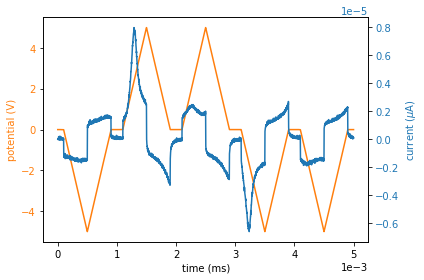

In [10]:
"""Plotting the current and voltage versus time on two separate y-axes."""
box = 'B'
sample = '2'
bias = 5 #V
file = [f for f in glob.glob(data_directory + box + "/FE PUND "+str(bias)+"V**[Harald"+box+"_"+sample+"_dev1*.csv")][0]
time, curr, pot = dataCollection(file)
fig, ax1 = plt.subplots()
color = "tab:orange"
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('potential (V)', color=color)
ax1.plot(time, pot, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('current ($\mu$A)', color=color)  # we already handled the x-label with ax1
ax2.plot(time, curr, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.ticklabel_format(axis='both', style='sci', scilimits=(-2,2), useOffset=None, useLocale=None, useMathText=None)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.title('current pulses at 5V for 4% La at 6§00 C')
figname = box+sample+"_5V_Current"
plt.show()

1
IV_meas/Harald B\FE PUND 5V [HaraldB_1_dev1_500C_8pc(6) _ 1_13_2020 3_21_48 PM].csv
0.06385074620376874
2
IV_meas/Harald B\FE PUND 5V [HaraldB_2_dev1_600C_8pc(2) _ 1_13_2020 3_06_07 PM].csv
17.15233724271244
4
IV_meas/Harald B\FE PUND 5V [HaraldB_4_dev1_500C_12pc(3) _ 1_13_2020 3_30_06 PM].csv
0.06315172906115651
5
IV_meas/Harald B\FE PUND 5V [HaraldB_5_dev1_600C_12pc(2) _ 1_13_2020 2_55_29 PM].csv
11.64947830537506
8
IV_meas/Harald B\FE PUND 5V [HaraldB_8_dev1_600C_16pc(5) _ 1_13_2020 2_46_35 PM].csv
0.13593263182355209


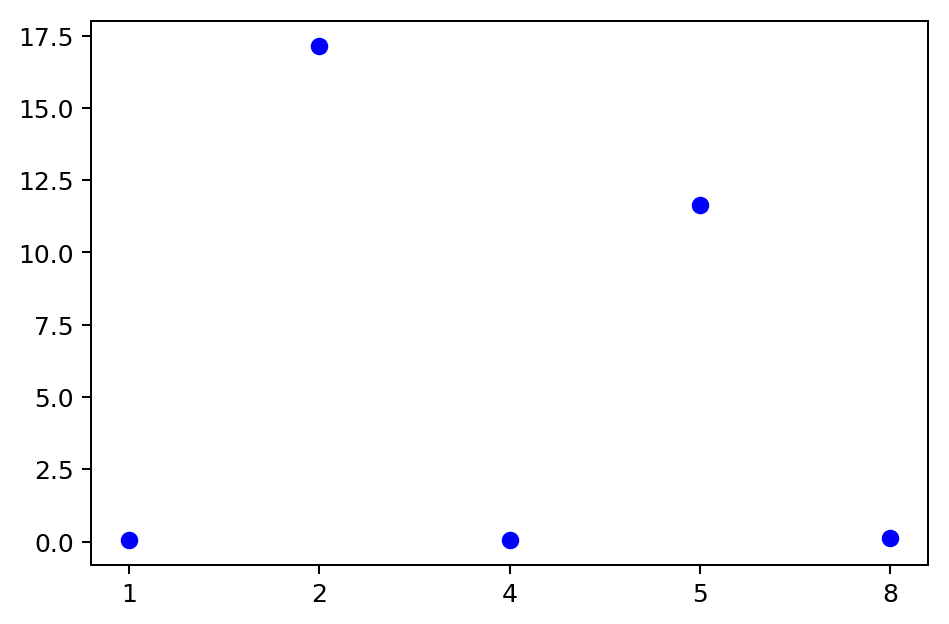

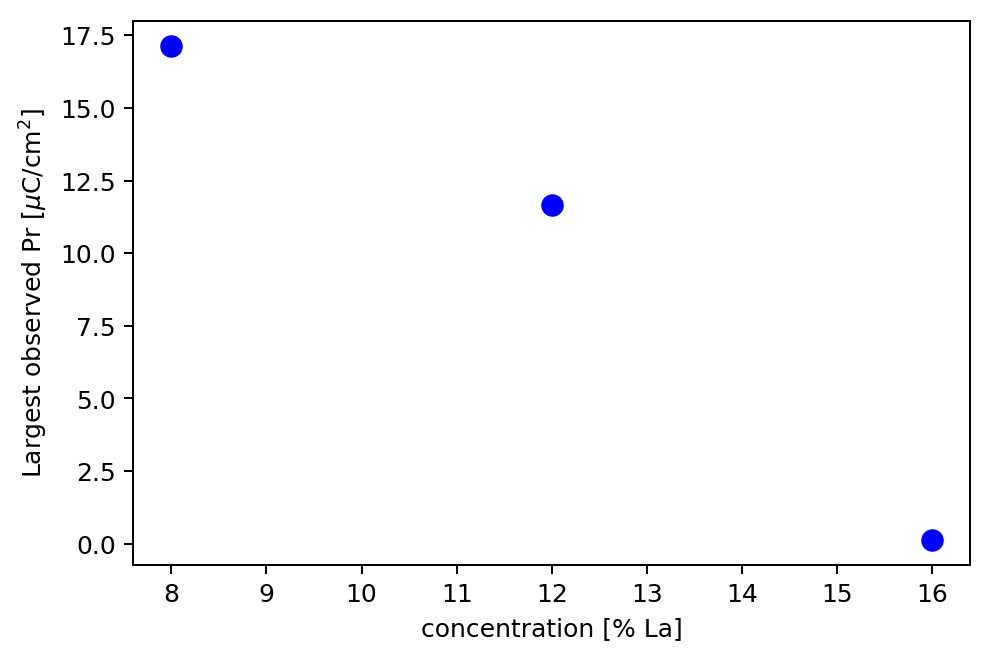

In [11]:
"""For any "box", plots the remanent polarization of the sample. 
Used to recap which samples in a box showed ferroelectricity..."""
box = 'B'
samples = ['1','2','3','4','5','6','7','8','9']
bias = 3 #V
pr_list = []
remove_samples = []
figure(dpi = 180)
for sample in samples:
    files = [f for f in glob.glob(data_directory + box + "/FE PUND 5V**[Harald"+box+"_"+sample[0]+"_dev1*.csv")]
    if len(files) != 0: #Finds samples which were measured on, i.e. those for which data exists
        #prints out the samples and filename, from printout the temperature and percentage lanthanum can be read out
        print(sample) 
        file = files[0]
        print(file)
        
        time, curr, pot = dataCollection(file)
        P, pr = PVChar(time, curr, pot, bias)
        pr_list.append(pr)
        print(pr)
    else: 
        remove_samples.append(sample)
for i in remove_samples:
    samples.remove(i)  
plt.plot(samples, pr_list, 'bo')
plt.show()
figure(dpi = 180)
plt.plot([8, 12, 16], [17.1478, 11.646, 0.1356], 'bo', ms = 8)
plt.xlabel('concentration [% La]')
plt.ylabel('Largest observed Pr [$\mu$C/cm$^2$]')
plt.show()

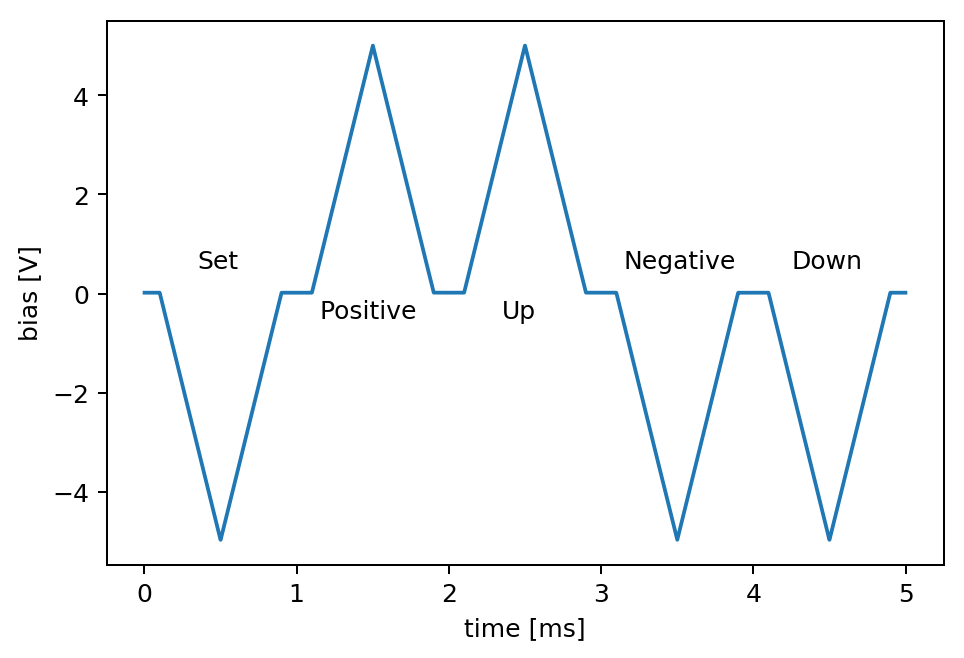

In [12]:
"""Illustration of the PUND schema with named peaks."""
bias = 5; box = "J"; sample = "2" #arbitrarily chosen...
file = [f for f in glob.glob(data_directory + box + "/FE PUND "+str(bias)+"V**[Harald"+box+"_"+sample+"_dev1*.csv")][0]
time, curr, pot = dataCollection(file)
from matplotlib.pyplot import figure
figure(num=None, dpi=180, facecolor='w', edgecolor='k')
plt.plot(time*1000, pot)
plt.xlabel('time [ms]')
plt.ylabel('bias [V]')
plt.text(0.35, 0.5, 'Set')
plt.text(1.15,-0.5, 'Positive')
plt.text(2.35,-0.5, 'Up')
plt.text(3.15, 0.5, 'Negative')
plt.text(4.25, 0.5, 'Down')
plt.show()

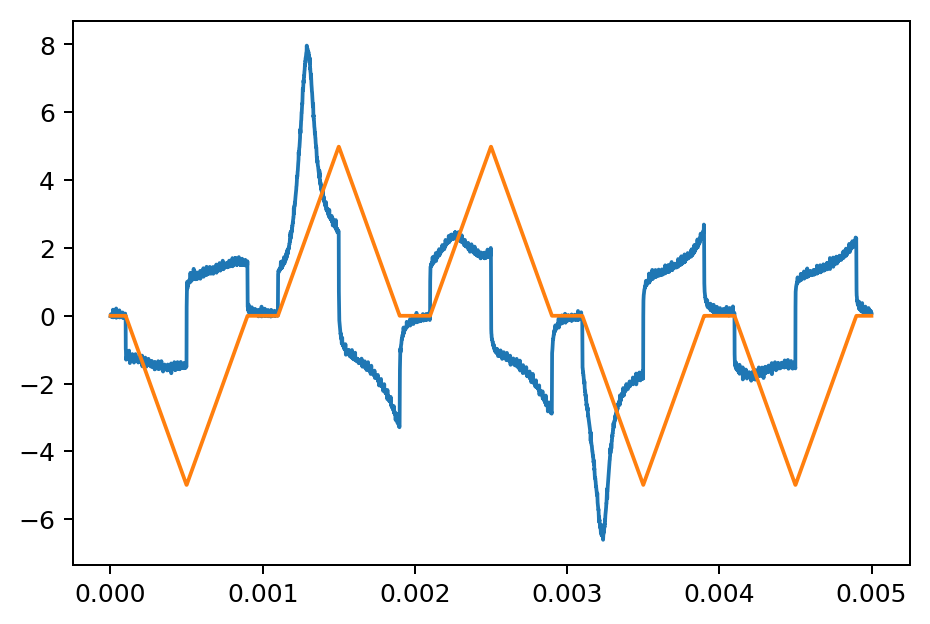

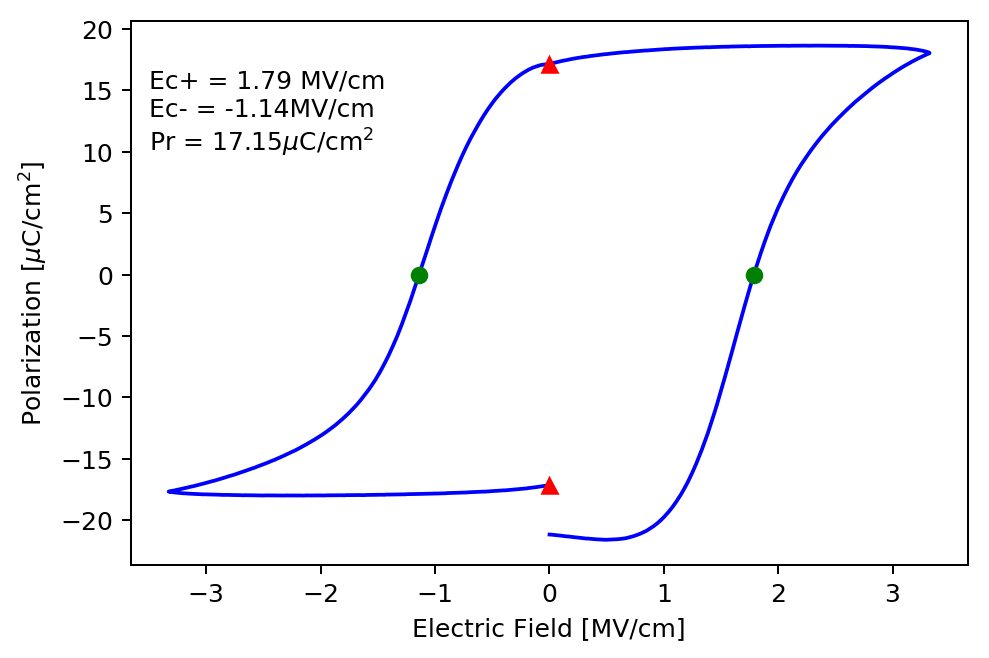

In [13]:
file = data_directory + 'B/FE PUND 5V [HaraldB_2_dev1_600C_8pc(2) _ 1_13_2020 3_06_07 PM].csv'
figure(dpi = 180)
indexnames = pd.read_csv(file, header = None, usecols = [0])
skiplist = []
c = 0

for item in indexnames.values[:]:
    if item != "DataValue":
        skiplist.append(c)
    c += 1
treated_data = pd.read_csv(file, header = [0, 4999], skiprows = skiplist, index_col = 0)
time = treated_data.values[1:,0].astype(float)
curr = treated_data.values[1:,1].astype(float)*-1
pot = treated_data.values[1:,2].astype(float)
plt.plot(time, curr*1E6)
plt.plot(time, pot)
plt.show()
figure(dpi = 180)
#plt.plot(time, pot)
P, pr = PVChar(time, curr, pot, 5)
P1 = P[1100:1900]-P[2100:2900]; P2 = P[3100:3900]-P[4100:4900]
P1 = P1 - (P1[-1]-pr); P2 = P2 - (P2[0]-pr)
pot1 = pot[1100:1900]/(1e6*15e-7); pot2 = pot[3100:3900]/(1e6*15e-7)
Ec1 = pot1[np.where(abs(P1) == min(abs(P1)))[0]]; Ec2 = pot2[np.where(abs(P2) == min(abs(P2)))[0]]
plt.plot(pot1, P1, 'b')
plt.plot(pot2, P2, 'b')
plt.plot([0,0],[pr,-pr],'r^')
plt.plot([Ec1, Ec2], [0,0],'go')
textstring = "Ec+ = " + str(round(Ec1[0],2)) +" MV/cm \n" + "Ec- = " + str(round(Ec2[0],2)) +"MV/cm \n" + "Pr = " + str(round(pr,2)) + "$\mu$C/cm$^2$"
plt.text(-3.5,10, textstring)
plt.xlabel('Electric Field [MV/cm]')
plt.ylabel('Polarization [$\mu$C/cm$^2$]')
#plt.savefig(homedir + '/IV_meas/PrResults/Hysteresis_loop_B2.png')
# plt.legend()
# plt.grid()
plt.show()

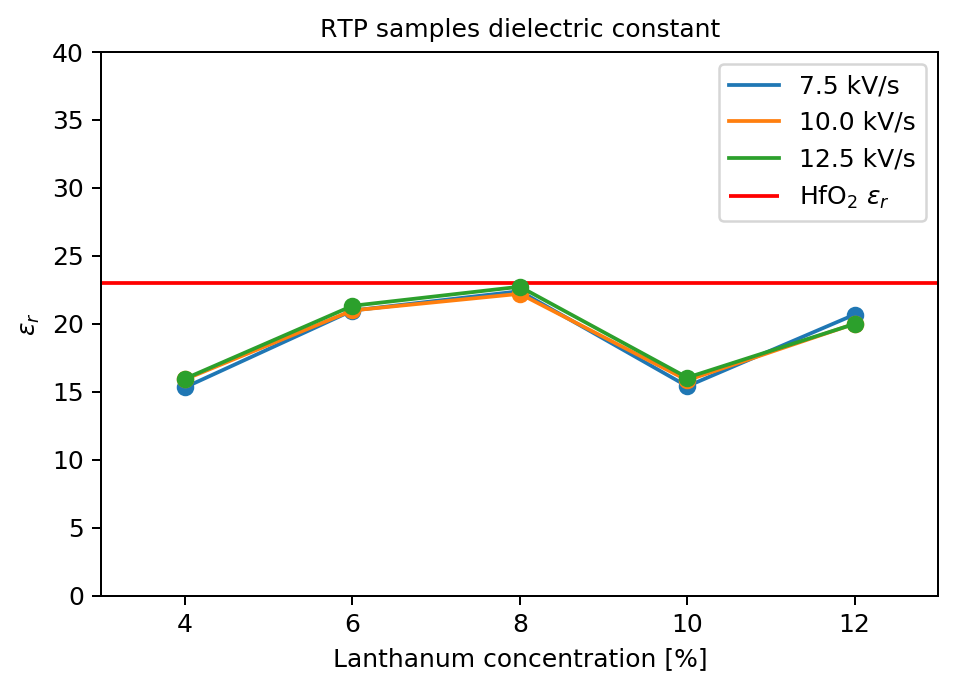

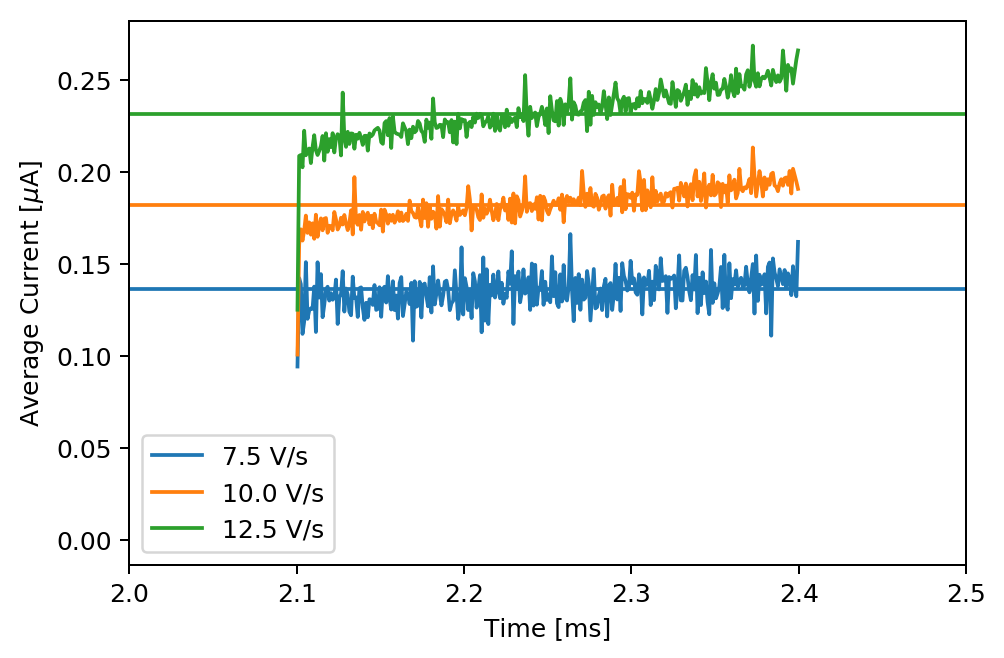

er = 19.20306169324838 +/- 2.7587705205423907


In [14]:
"""Finding capacitance to find epsilon for the samples at varying concentration"""
boxes = ['G', 'H', 'E', 'I', 'J']
concs = [4,6,8,10,12]
sample = '1'
biases = [3,4,5]
fig1, ax1 = plt.subplots(dpi = 180)
fig2, ax2 = plt.subplots(dpi = 180)
min_curr = 0; max_curr = 0
for i, bias in enumerate(biases):
    er_list = []
    color = next(ax2._get_lines.prop_cycler)['color']
    plt.plot(0.0025,0,color = color, label = str(float(bias)/0.4) + " V/s")
    for j, box in enumerate(boxes):
        conc = concs[j]
        file = [f for f in glob.glob(data_directory + box + "/FE PUND "+str(bias)+"V**[Harald"+box+"_"+sample[0]+"_dev1*.csv")][0]
#         print(file)
        time, curr, pot = dataCollection(file)
        p1 = 100
        p2 = 400
        C1 = Capacitance(time[2000+p1:2000+p2], curr[2000+p1:2000+p2], pot[2000+p1:2000+p2])
        C2 = Capacitance(time[4000+p1:4000+p2], curr[4000+p1:4000+p2], pot[4000+p1:4000+p2])
        if box == "G":
            m1 = np.median(curr[2000+p1:2000+p2])*1e6; m2 = np.median(curr[4000+p1:4000+p2])*1e6
            min_curr = min(min(curr), min_curr); max_curr = max(max(curr), max_curr)
            #ax2.hlines(m1, xmin = 0, xmax = 5)
            #ax2.hlines(m2, xmin = 0, xmax = 5)
            offset = m1+m2
            mean_curr = (m1-m2)/2
            #ax2.plot(time*1e3, (curr)*1e6-offset/2, color = color)
            ax2.plot(time[2000+p1:2000+p2]*1e3, curr[2000+p1:2000+p2]*1e6-offset/2, color = color)
            ax2.hlines(mean_curr, xmin = 0, xmax = 5, color = color)
            #ax2.hlines(-mean_curr, xmin = 0, xmax = 5, color = color)
            #ax2.plot(time[2100:2400], pot[2100:2400])
        e0 = 8.854e-12
        er1 = C1*15e-9/(e0*(np.pi*(25e-6)**2))
        er2 = C2*15e-9/(e0*(np.pi*(25e-6)**2))
        er = np.mean([er1, er2])
#         print(er)
        er_list.append(er)
    color1 = next(ax1._get_lines.prop_cycler)['color']
    ax1.plot(concs, er_list, color = color1, label = str(biases[i]/0.4) + ' kV/s')
    ax1.plot(concs, er_list, 'o', color = color1)
ax2.legend()
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Average Current [$\mu$A]')
ax2.set_ylim()
ax2.set_xlim(2,2.5)
# ax2.set_title("Extracted currents for 4 % La")
# ax2.set_xlim(2,2.5)
ax1.set_ylabel('$\epsilon_r$')
ax1.set_xlabel('Lanthanum concentration [%]')
ax1.set_title('RTP samples dielectric constant')
ax1.set_ylim(0,40)
ax1.set_xlim(3,13)
ax1.hlines(23, 3, 13, color = 'red', label = "HfO$_2$ $\epsilon_r$")
ax1.legend()
plt.show()
print("er = "+str(np.mean(er_list))+" +/- " + str(np.std(er_list)))

G 3 7
IV_meas/Harald G\FE PUND 3V [HaraldG_7_dev2(4) _ 2020-03-27 09_30_29].csv
3 G 7
21.214015061527085
G 3 8
IV_meas/Harald G\FE PUND 3V [HaraldG_8_dev2(4) _ 2020-03-27 09_42_59].csv
3 G 8
21.214520016750285
G 3 9
IV_meas/Harald G\FE PUND 3V [HaraldG_9_dev2(8) _ 2020-03-27 09_47_36].csv
3 G 9
21.30268386595307
G 4 7
IV_meas/Harald G\FE PUND 4V [HaraldG_7_dev2(4) _ 2020-03-27 09_30_47].csv
4 G 7
21.18971843430436
G 4 8
IV_meas/Harald G\FE PUND 4V [HaraldG_8_dev2(4) _ 2020-03-27 09_43_17].csv
4 G 8
21.655648578247327
G 4 9
IV_meas/Harald G\FE PUND 4V [HaraldG_9_dev2(8) _ 2020-03-27 09_47_54].csv
4 G 9
20.863576628910437
G 5 7
IV_meas/Harald G\FE PUND 5V [HaraldG_7_dev2(4) _ 2020-03-27 09_31_06].csv
5 G 7
21.547400448680584
G 5 8
IV_meas/Harald G\FE PUND 5V [HaraldG_8_dev2(4) _ 2020-03-27 09_43_36].csv
5 G 8
21.416672277389207
G 5 9
IV_meas/Harald G\FE PUND 5V [HaraldG_9_dev2(8) _ 2020-03-27 09_48_13].csv
5 G 9
20.895476211398062


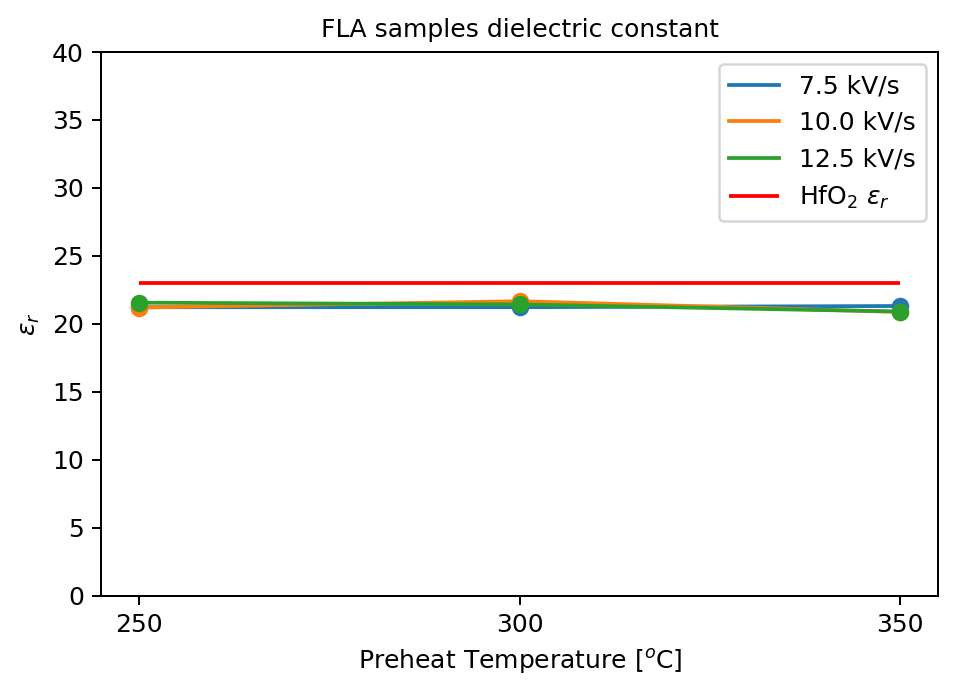

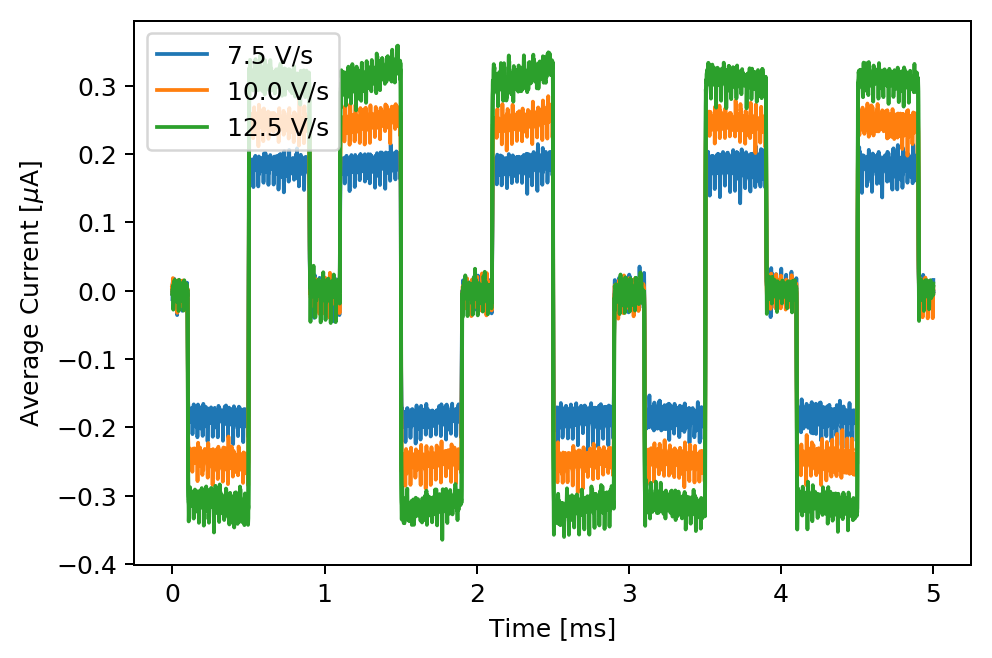

0.2816105279617837
21.286516312489283


In [15]:
"""Dielectric constant for the FLA samples."""
box = 'G'
concs = [4]
samples = ['7','8','9']
biases = [3,4,5]
temps = [250, 300, 350]
fig1, ax1 = plt.subplots(dpi = 180)
fig2, ax2 = plt.subplots(dpi = 180)
min_curr = 0; max_curr = 0
for i, bias in enumerate(biases):
    er_list = []
    color = next(ax2._get_lines.prop_cycler)['color']
    plt.plot(0.0025,0,color = color, label = str(float(bias)/0.4) + " V/s")
    for j, sample in enumerate(samples):
        print(box, bias, sample)
        file = [f for f in glob.glob(data_directory + box + "/FE PUND "+str(bias)+"V**[Harald"+box+"_"+sample[0]+"_dev2*.csv")][0]
        print(file)
        time, curr, pot = dataCollection(file)
        p1 = 100
        p2 = 400
        C1 = Capacitance(time[2000+p1:2000+p2], curr[2000+p1:2000+p2], pot[2000+p1:2000+p2])
        C2 = Capacitance(time[4000+p1:4000+p2], curr[4000+p1:4000+p2], pot[4000+p1:4000+p2])
        if box == "G":
            m1 = np.median(curr[2000+p1:2000+p2])*1e6; m2 = np.median(curr[4000+p1:4000+p2])*1e6
            min_curr = min(min(curr), min_curr); max_curr = max(max(curr), max_curr)
            offset = m1+m2
            mean_curr = (m1-m2)/2
            ax2.plot(time*1e3, (curr)*1e6-offset/2, color = color)
        print(bias, box, sample)
        e0 = 8.854e-12
        er1 = C1*15e-9/(e0*(np.pi*(25e-6)**2))
        er2 = C2*15e-9/(e0*(np.pi*(25e-6)**2))
        er = np.mean([er1, er2])
        print(er)
        er_list.append(er)
    color1 = next(ax1._get_lines.prop_cycler)['color']
    ax1.plot(temps, er_list, color = color1, label = str(biases[i]/0.4) + ' kV/s')
    ax1.plot(temps, er_list, 'o', color = color1)
ax2.legend()
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Average Current [$\mu$A]')
ax2.set_ylim()
# ax2.set_title("Extracted currents for 4 % La")
# ax2.set_xlim(2,2.5)
ax1.set_ylabel('$\epsilon_r$')
ax1.set_xlabel('Preheat Temperature [$^o$C]')
ax1.set_ylim(0,40)
ax1.set_title('FLA samples dielectric constant')
ax1.set_xticks([250,300,350])
ax1.set_xticklabels([250,300,350])
# ax1.set_xlim(3,13)
ax1.hlines(23, 250, 350, color = 'red', label = "HfO$_2$ $\epsilon_r$")
ax1.legend()
plt.show()
print(np.std(er_list))
print(np.mean(er_list))

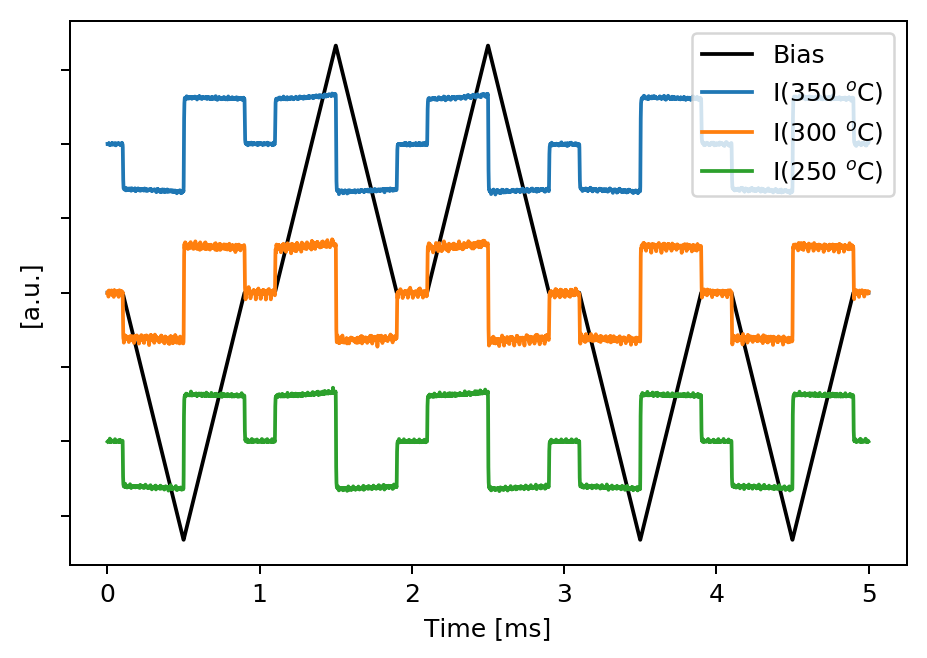

In [16]:
"""FLA currents plotted parallel to each other to highlight the non-existence of FE peaks. """
biases = [3,4,5]
boxes = ['G']
concs = [4]
samples = ['7','8','9']
temps = [350,300,250]
fig2, ax2 = plt.subplots(dpi = 180)
min_curr = 0; max_curr = 0
er_list = []
ax2.plot(time*1000, pot/3, label = 'Bias', color = 'k')
for i, sample in enumerate(samples):
    color = next(ax2._get_lines.prop_cycler)['color']
    for box in boxes:
        file = [f for f in glob.glob(data_directory + box + "/FE PUND "+str(bias)+"V**[Harald"+box+"_"+sample[0]+"_dev2*.csv")][0]
        time, curr, pot = dataCollection(file)
        ax2.plot(time*1e3, curr*1e6-(i-1)*1, color = color, label = "I("+str(temps[i]) + " $^o$C"+")", ls = "-")
ax2.legend()
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('[a.u.]')
ax2.set_yticklabels('')
ax2.set_ylim()
plt.show()